## Construção do modelo de classificação:
Implementar um modelo de clustering usando o algoritmo K-Means para segmentar os clientes em grupos homogêneos baseados em suas características demográficas e comportamentais.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    OrdinalEncoder,
    OneHotEncoder, 
    PowerTransformer,
    StandardScaler,
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression,  SGDClassifier

#estudo knn
from sklearn.neighbors import KNeighborsClassifier

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#estudo SGD
SGDClassifier

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

# exportar o modelo
from joblib import dump

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_LIMPOS,  MODELO_FINAL
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

#pandas configurando para mostrar todas as linhas e colunas
pd.set_option ('display.max_columns', None)
#configurando pandas para não mostrar notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)


sns.set_theme(palette='viridis')


In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,Idade,Attrition,Viagens trab,Tarifa diária,Departamento,Distância casa,Formação acad,Área form,Satisf amb,Gênero,Tarifa hora,Envolv trab,Nível cargo,Cargo,Satisf trab,Estado civil,Renda mensal,Tarifa mensal,Nº empresas trab,Hora extra,% aumento sal,Avaliação desemp,Satisf relac,Opc ações,Anos traba,Treinam ultm ano,Equil vida-trab,Anos empresa,Anos cargo atual,Anos ult prom,Anos gerente atual
0,41,Sim,Raramente,1102,Vendas,1.61,2,Ciências biológicas,2,Feminino,94,3,2,Executivo de vendas,4,Solteiro,5993,19479,8,Sim,11,3,1,0,8,0,1,6,4,0,5
1,49,Não,Frequentemente,279,Pesquisa e Desenvolvimento,12.87,1,Ciências biológicas,3,Masculino,61,2,2,Cientista pesquisador,2,Casado,5130,24907,1,Não,23,4,4,1,10,3,3,10,7,1,7
2,37,Sim,Raramente,1373,Pesquisa e Desenvolvimento,3.22,2,Outros,4,Masculino,92,2,1,Técnico de laboratório,3,Solteiro,2090,2396,6,Sim,15,3,2,0,7,3,3,0,0,0,0
3,33,Não,Frequentemente,1392,Pesquisa e Desenvolvimento,4.83,4,Ciências biológicas,4,Feminino,56,3,1,Cientista pesquisador,3,Casado,2909,23159,1,Sim,11,3,3,0,8,3,3,8,7,3,0
4,27,Não,Raramente,591,Pesquisa e Desenvolvimento,3.22,1,Ciências médicas,1,Masculino,40,3,1,Técnico de laboratório,2,Casado,3468,16632,9,Não,12,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Idade               1470 non-null   int64  
 1   Attrition           1470 non-null   object 
 2   Viagens trab        1470 non-null   object 
 3   Tarifa diária       1470 non-null   int64  
 4   Departamento        1470 non-null   object 
 5   Distância casa      1470 non-null   float64
 6   Formação acad       1470 non-null   int64  
 7   Área form           1470 non-null   object 
 8   Satisf amb          1470 non-null   int64  
 9   Gênero              1470 non-null   object 
 10  Tarifa hora         1470 non-null   int64  
 11  Envolv trab         1470 non-null   int64  
 12  Nível cargo         1470 non-null   int64  
 13  Cargo               1470 non-null   object 
 14  Satisf trab         1470 non-null   int64  
 15  Estado civil        1470 non-null   object 
 16  Renda 

In [4]:
# Agrupamento das colunas de acordo com o pré-processamento necessário
colunas_categoricas_nao_ordenadas = [
    'Viagens trab',
    'Departamento',
    'Área form',
    'Gênero',
    'Cargo',
    'Estado civil',
    'Hora extra'
]
colunas_categoricas_ordenadas = [
    'Satisf amb',
    'Formação acad',
    'Satisf trab',
    'Envolv trab',
    'Nível cargo',
    'Avaliação desemp',
    'Satisf relac',
    'Opc ações',
    'Equil vida-trab',
     
]
coluna_target= ['Attrition']

colunas_numericas = [coluna for coluna in df.columns if coluna not in (
    colunas_categoricas_nao_ordenadas+colunas_categoricas_ordenadas+coluna_target)
                              ]

Na EDA foi possível perceber que alguma scolunas nuiméricas tinham uma distribuição bem distinta, que não se aproximava a distribuição normal: 'DailyRate', 'HourlyRate', 'MonthilyRate'. Nesses casos vou usar o MinMaxScaler para trabalhar o escalonamento sem focar na distribuição.
A coluna Age apresenta uma distribuição próxima do normal, por isso vou usar o StandarScaler e para as demais usarei o PowerTransformer para transformar os valores em uma distribuição mais normal.


In [5]:
colunas_numericas_min_max = [ coluna for coluna in df.filter(like='Tarifa').columns]
colunas_numericas_min_max

coluna_numerica_std= ['Idade']
colunas_numericas_power_transformer= [coluna for coluna in colunas_numericas if coluna not in (
    coluna_numerica_std +colunas_numericas_min_max)
]
colunas_numericas_power_transformer

['Distância casa',
 'Renda mensal',
 'Nº empresas trab',
 '% aumento sal',
 'Anos traba',
 'Treinam ultm ano',
 'Anos empresa',
 'Anos cargo atual',
 'Anos ult prom',
 'Anos gerente atual']

In [6]:
X= df.drop(columns=coluna_target)
y= df[coluna_target]


In [7]:
#codificação da coluna target
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())
y

array([1, 0, 1, ..., 0, 0, 0])

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Fluxo da Análise:
1. Pré-processamento dos Dados:
Transformação de Variáveis:

Variáveis categóricas são codificadas via OneHotEncoder

Variáveis numéricas serão escalonadas


In [9]:
# Preprocessamento
preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'),colunas_categoricas_ordenadas),
        ('min_max', MinMaxScaler(), colunas_numericas_min_max),
        ('standard', StandardScaler(), coluna_numerica_std),
        ('power_transformer', PowerTransformer(), colunas_numericas_power_transformer)
    ]
)

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'),colunas_categoricas_ordenadas),
    ]
)

In [10]:
#para base desbalanceada em modelos de árvores
scale_pos_weight = np.bincount(y)[0]/ np.bincount(y)[1]
scale_pos_weight 

5.2025316455696204

In [11]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified")
    },
    
     "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(
            class_weight= 'balanced'
        )
    },
     
    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC()
    },

     "KneighborsClassifier":{
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier()
           
    }, 
    "SGDClassifier": {
        "preprocessor": preprocessamento,
        "classificador": SGDClassifier()
    },
  
    # modelos baseado em árvores de decisão

      "DecisionTreeClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": DecisionTreeClassifier(class_weight= 'balanced')
    },

    
     "XGBClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )
     },

    "LGBMClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight,
            verbose=-1
        )
    }, 
   
}

In [12]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.00,0.02,0.73,0.51,0.19,0.19,0.19,0.52,0.17,0.03
1,DummyClassifier,0.00,0.02,0.71,0.49,0.16,0.15,0.17,0.55,0.18,0.02
2,DummyClassifier,0.00,0.02,0.73,0.49,0.15,0.15,0.15,0.54,0.17,0.02
3,DummyClassifier,0.00,0.02,0.72,0.47,0.11,0.11,0.11,0.48,0.16,0.02
4,DummyClassifier,0.00,0.02,0.72,0.48,0.13,0.13,0.13,0.55,0.18,0.03
5,LogisticRegression,0.32,0.08,0.74,0.72,0.46,0.35,0.69,0.82,0.57,0.40
6,LogisticRegression,0.26,0.12,0.77,0.76,0.51,0.39,0.75,0.84,0.62,0.38
7,LogisticRegression,0.21,0.08,0.75,0.75,0.49,0.36,0.74,0.84,0.64,0.29
8,LogisticRegression,0.19,0.07,0.79,0.77,0.53,0.41,0.74,0.84,0.65,0.26
9,LogisticRegression,0.26,0.06,0.77,0.75,0.50,0.39,0.72,0.79,0.58,0.32


In [13]:
#vou usar a métrica average_precision por combinar as métricas precisão e recall dando peso a ambas.
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.00,0.02,0.72,0.49,0.15,0.14,0.15,0.53,0.17,0.02
DecisionTreeClassifier,0.04,0.04,0.78,0.61,0.34,0.34,0.34,0.61,0.23,0.08
KneighborsClassifier,0.10,0.32,0.84,0.55,0.20,0.62,0.12,0.68,0.33,0.42
XGBClassifier,0.38,0.05,0.82,0.66,0.44,0.45,0.43,0.77,0.46,0.43
LGBMClassifier,1.22,0.06,0.82,0.69,0.47,0.46,0.48,0.80,0.51,1.27
SGDClassifier,0.12,0.06,0.86,0.63,0.39,0.70,0.30,0.80,0.53,0.18
LogisticRegression,0.25,0.08,0.76,0.75,0.50,0.38,0.73,0.82,0.61,0.33
SVC,0.17,0.14,0.86,0.59,0.30,0.86,0.19,0.83,0.63,0.30


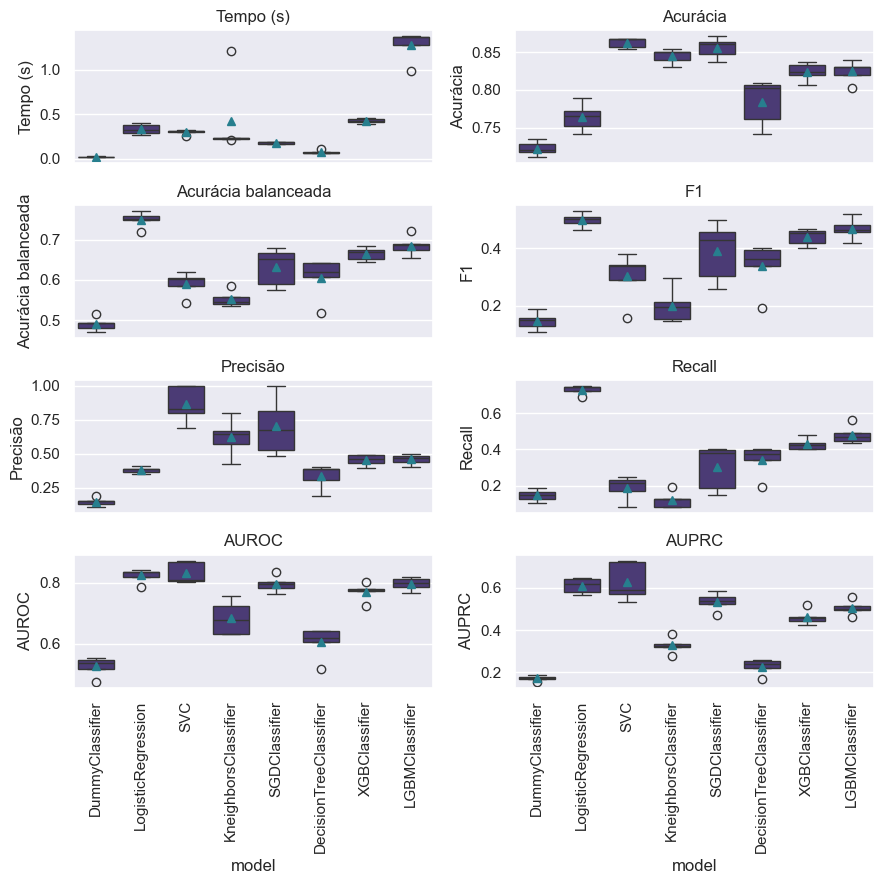

In [14]:
plot_comparar_metricas_modelos(df_resultados)

3. Aplicação da Regressão Logística:
   
Modelo treinado com n_clusters=5 e random_state=42 para reprodutibilidade

Pipeline integrando pré-processamento e modelagem

In [15]:
#como eu vou testar todos os solvers, receberei diversos avisos, uma vez que apenas o saga é compatível como o ElasticNet

param_grid= {
    "clf__C":[0.1, 1, 10, 100],
    "clf__penalty": ['l1','l2', 'elasticnet', None],
    'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [16]:
clf = LogisticRegression(random_state=RANDOM_STATE, solver='saga', class_weight='balanced') #para base de dado grande, o saga é indicado
grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric = "average_precision", 
)
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Viagens '
                                                                          'trab',
                                                                          'Departamento',
                                                                          'Área '
                                                                          'form',
                                                                          'Gênero',
                                                                          'Cargo',
                                                                          'Estado '
                                                                          'civil',
                                                                          'Hora '
                                                                          'extra']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Satisf '
                                                                          'amb',
                                                                          'Formação '
                                                                          'acad',
                                                                          'Satisf '
                                                                          't...
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [17]:
grid_search.fit(X,y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


D:\ProgramFiles\anaconda\env\machine_learning\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Viagens '
                                                                          'trab',
                                                                          'Departamento',
                                                                          'Área '
                                                                          'form',
                                                                          'Gênero',
                                                                          'Cargo',
                                                                          'Estado '
                                                                          'civil',
                                                                          'Hora '
                                                                          'extra']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Satisf '
                                                                          'amb',
                                                                          'Formação '
                                                                          'acad',
                                                                          'Satisf '
                                                                          't...
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [18]:
grid_search.best_params_
#L1_ratio só faz sentido com Elastic Net

{'clf__C': 0.1, 'clf__l1_ratio': 0.1, 'clf__penalty': 'l2'}

In [19]:
grid_search.best_score_

0.6290036505106608

In [20]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Viagens trab',
                                                   'Departamento', 'Área form',
                                                   'Gênero', 'Cargo',
                                                   'Estado civil',
                                                   'Hora extra']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Satisf amb',
                                                   'Formação acad',
                                                   'Satisf trab', 'Envolv trab',
                                                   'Nível cargo',
                                                   'Avaliação desemp',
                                                   'Satisf relac', 'Opc ações',
                                                   'Equil vida-trab']),
                                                 ('mi...
                                                   'Tarifa mensal']),
                                                 ('standard', StandardScaler(),
                                                  ['Idade']),
                                                 ('power_transformer',
                                                  PowerTransformer(),
                                                  ['Distância casa',
                                                   'Renda mensal',
                                                   'Nº empresas trab',
                                                   '% aumento sal',
                                                   'Anos traba',
                                                   'Treinam ultm ano',
                                                   'Anos empresa',
                                                   'Anos cargo atual',
                                                   'Anos ult prom',
                                                   'Anos gerente atual'])])),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.1, random_state=42,
                                    solver='saga'))])

In [21]:
#avaliar oos resultados de outras métricas e o desvio padrão
colunas_teste= [coluna for coluna in df_resultados.columns if coluna.startswith('test')]
colunas_teste


['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [22]:
colunas_test_mean = ['mean_'+coluna for coluna in colunas_teste]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [23]:
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results = cv_results[colunas_test_mean].iloc[grid_search.best_index_ , :]

cv_results.T

mean_test_accuracy            0.77
mean_test_balanced_accuracy   0.75
mean_test_f1                  0.50
mean_test_precision           0.38
mean_test_recall              0.73
mean_test_roc_auc             0.83
mean_test_average_precision   0.63
Name: 1, dtype: float64

In [24]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out() #o nome das features
)
coefs  

,coeficiente
one_hot__Viagens trab_Não viaja,-0.94
power_transformer__Renda mensal,-0.45
one_hot__Viagens trab_Raramente,-0.44
ordinal__Envolv trab,-0.43
one_hot__Estado civil_Divorciado,-0.39
power_transformer__Anos traba,-0.36
ordinal__Satisf amb,-0.35
min_max__Tarifa diária,-0.33
one_hot__Cargo_Diretor de pesquisa,-0.32
ordinal__Satisf trab,-0.32


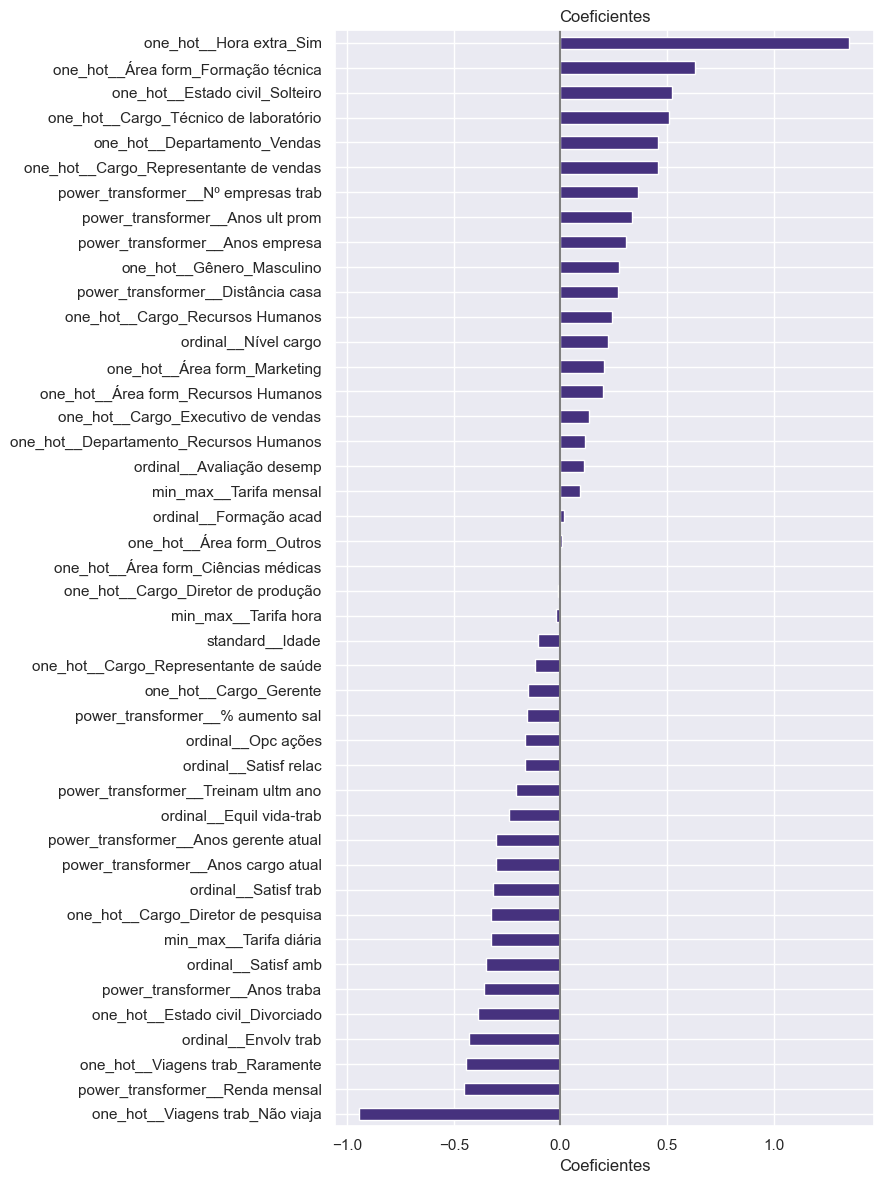

In [25]:
plot_coeficientes(coefs.query('coeficiente != 0'))

#O Departamento de Pesquisa e Desenvolvimento tem mais pessoas e isso pode influenciar o resultado.

Os coeficientes hora extra, viagem a trabalho frequentemente, pessoas solteiras e pessoas com formação técnica são mais altos em relação ao attrition 

In [26]:
#transformar em odds para facilitar o entendimento
coefs_odds = coefs.copy()
coefs_odds["coeficiente"] = np.exp(coefs_odds["coeficiente"])

coefs_odds['coeficiente'].sort_values(ascending=False)

one_hot__Hora extra_Sim                  3.88
one_hot__Área form_Formação técnica      1.88
one_hot__Estado civil_Solteiro           1.68
one_hot__Cargo_Técnico de laboratório    1.67
one_hot__Departamento_Vendas             1.58
one_hot__Cargo_Representante de vendas   1.58
power_transformer__Nº empresas trab      1.44
power_transformer__Anos ult prom         1.40
power_transformer__Anos empresa          1.36
one_hot__Gênero_Masculino                1.31
power_transformer__Distância casa        1.31
one_hot__Cargo_Recursos Humanos          1.28
ordinal__Nível cargo                     1.25
one_hot__Área form_Marketing             1.23
one_hot__Área form_Recursos Humanos      1.22
one_hot__Cargo_Executivo de vendas       1.15
one_hot__Departamento_Recursos Humanos   1.12
ordinal__Avaliação desemp                1.12
min_max__Tarifa mensal                   1.10
ordinal__Formação acad                   1.02
one_hot__Área form_Outros                1.01
one_hot__Área form_Ciências médica

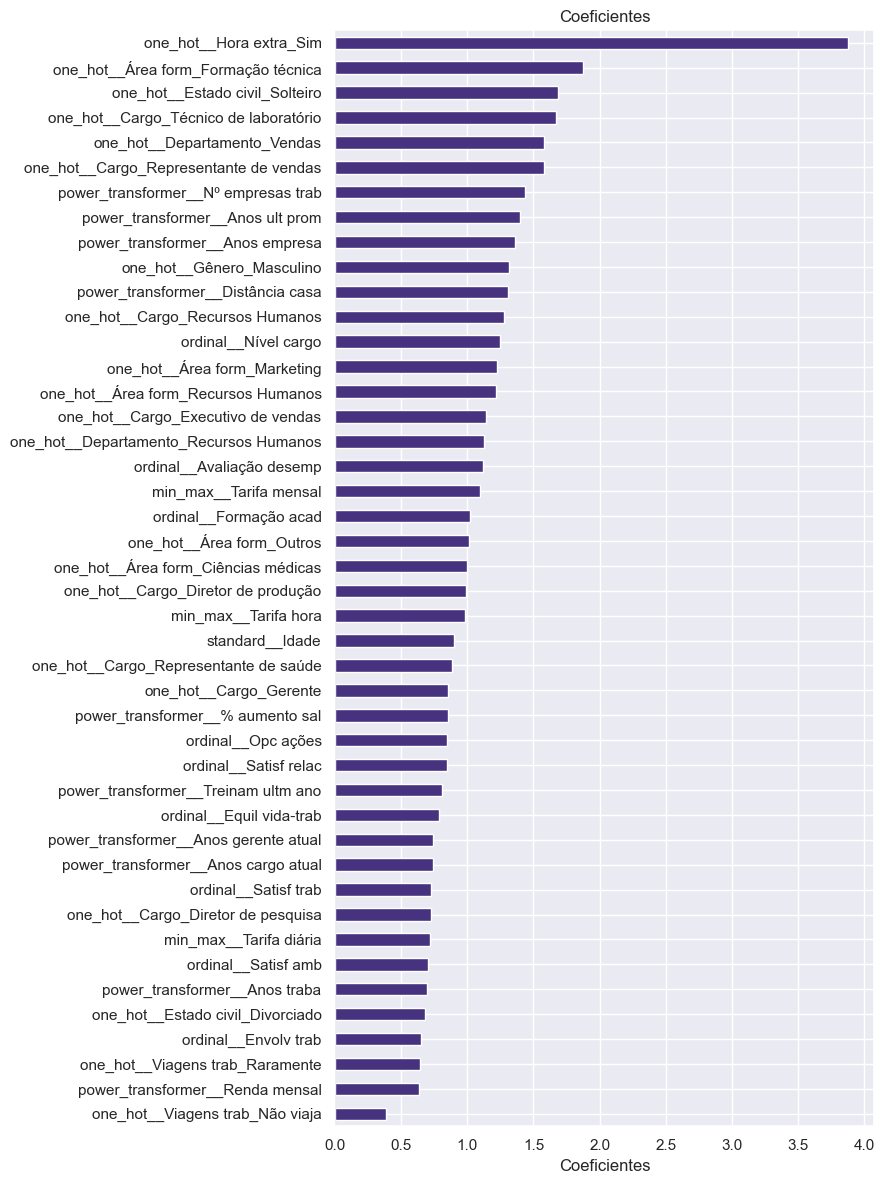

In [27]:
plot_coeficientes(coefs_odds.query("coeficiente != 1"))

Os funcionários que fazem hora extra com frequência tem 3.8 x mais chance de pedir demissão, seguido por quem viagem frequentemente( 2.11) e por quem é solteiro (1.83) em relação aos que não fazem.
Os funcionários que  se sentem envolvidos com o trabalho, com a renda mensal alta e satisfação com o ambiente de trabalho possuem 0.6x menos chance de pedir demissão em relação aos demais


<function matplotlib.pyplot.show(close=None, block=None)>

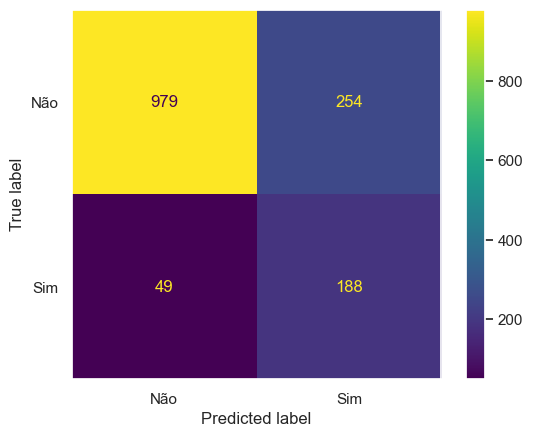

In [28]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,

)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

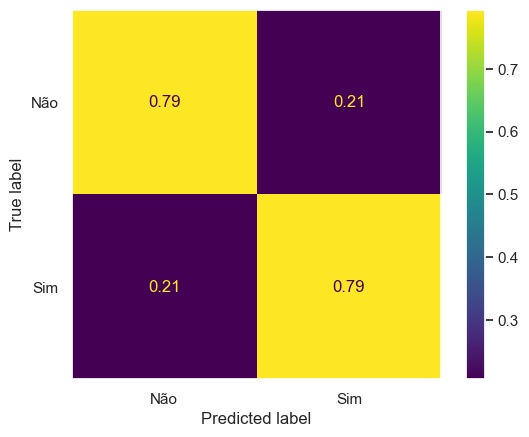

In [29]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize='true',

)
plt.grid(False)
plt.show

In [30]:
dump(grid_search.best_estimator_, MODELO_FINAL)


['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\projeto_ibm - Copia\\modelos\\logistic_regression.joblib']

## Conclusão

Os funcionários que fazem hora extra com frequência tem 3.8 x mais chance de pedir demissão, seguido por quem viagem frequentemente( 2.11) e por quem é solteiro (1.83) em relação aos que não fazem. Os funcionários que se sentem envolvidos com o trabalho, com a renda mensal alta e satisfação com o ambiente de trabalho possuem 0.6x menos chance de pedir demissão em relação aos demais

Plano de ação

Avaliar os motivos que levam os funcionários a fazerem hora extra.

    Mão de obra insuficiente
    
    Falta de organização institucional
    
    Falta de treinamento
    
    Necessidade de investimento em tecnologia
    
Possibilidade de diminuir as viagens de negócios.

    Como isso afeta a equipe de vendas?
    
Como a renda mensal de cada setor e nível da empresa se compara com o mercado?

Ações voltadas para o clima organizacional 
